<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [ ]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Посмотрим на какую-нибудь картинку:

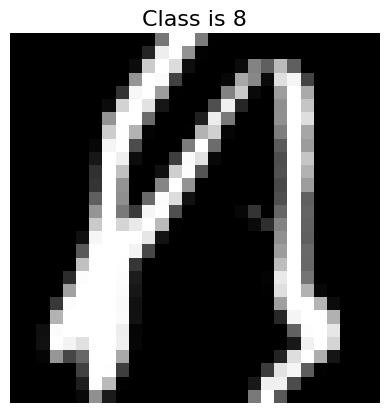

In [ ]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [ ]:
list(set(trainset.targets.numpy()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

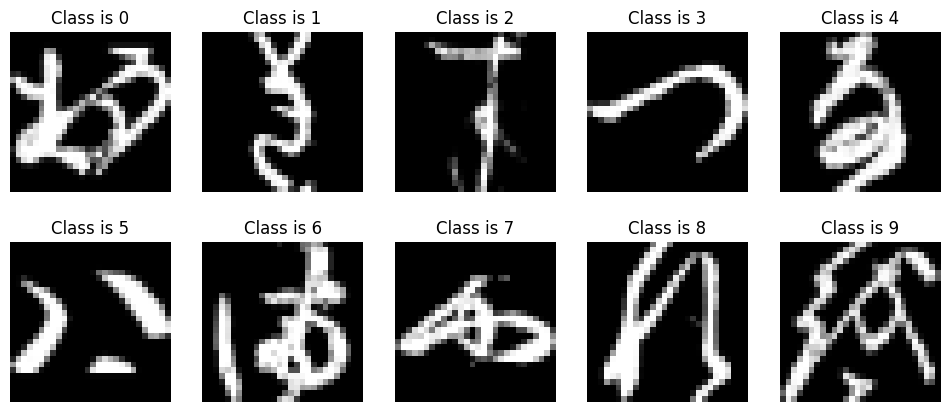

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(12,5))

for i in list(set(trainset.targets.numpy())):
  j = 0
  while trainset[j][1] != i:
    j += 1

  ax[i//5, i%5].imshow(trainset[j][0].view(28, 28).numpy(), cmap="gray")
  ax[i//5, i%5].axis("off")
  ax[i//5, i%5].set_title(f"Class is {trainset[j][1]}");

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        # Тут можно сделать многое: передавать число слоев, входных признаков и тд
        # но пока что ограничимся чем-то простым

        super().__init__() # Не нужно забывать про это, иначе ничего не сработает

        # Опрелелим два слоя
        # fc - fully connected (по сути значит линейные слои)

        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x # logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

Количество обучаемых параметров в FCNet можно вычислить как сумму параметров в каждом из линейных слоев. Каждый линейный слой имеет матрицу весов размера (output_features, input_features) и вектор смещений размера (output_features), поэтому общее количество обучаемых параметров можно вычислить следующим образом:


```
params = (input_features * output_features) + output_features
```



In [ ]:
# for FCNet
fc1_params = (28*28 * 256) + 256
fc2_params = (256 * 2128) + 2128
fc3_params = (2128 * 10) + 10

params_total = fc1_params + fc2_params + fc3_params
params_total

769146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [ ]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.7042
Epoch=2 loss=0.3242
Epoch=3 loss=0.2308
Epoch=4 loss=0.1775
Epoch=5 loss=0.1378
Epoch=6 loss=0.1105
Epoch=7 loss=0.0873
Epoch=8 loss=0.0701
Epoch=9 loss=0.0558
Epoch=10 loss=0.0436


In [ ]:
get_accuracy(fc_net, testloader)

0.9041

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
mean = np.array([images.mean().item() for images, labels in trainloader]).mean()
std = np.array([images.std().item() for images, labels in trainloader]).std()
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

0.19178504950188577 0.003183476582029937


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.0901
Epoch=2 loss=0.2032
Epoch=3 loss=0.0983
Epoch=4 loss=0.0552
Epoch=5 loss=0.0411
Epoch=6 loss=0.0381
Epoch=7 loss=0.0549
Epoch=8 loss=0.0717
Epoch=9 loss=0.0578
Epoch=10 loss=0.0529


In [ ]:
get_accuracy(fc_net, testloader)

0.8684

Как изменилась `accuracy` после нормализации?

**Ответ:** Уменьшилось

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
## YOUR CODE HERE
class MyFCNet(nn.Module):
    def __init__(self, last_func):
        # Тут можно сделать многое: передавать число слоев, входных признаков и тд
        # но пока что ограничимся чем-то простым

        super().__init__() # Не нужно забывать про это, иначе ничего не сработает

        # Опрелелим два слоя
        # fc - fully connected (по сути значит линейные слои)

        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)

        # activation function
        self.last_func = last_func
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.last_func(x)
        x = self.fc3(x)

        return x # logits

In [ ]:
n_epochs = 10

sigmoid = MyFCNet(F.sigmoid)
gelu = MyFCNet(F.gelu)
tanh = MyFCNet(F.tanh)

optimizer1 = torch.optim.Adam(sigmoid.parameters(), lr=3e-4)
optimizer2 = torch.optim.Adam(gelu.parameters(), lr=3e-4)
optimizer3 = torch.optim.Adam(tanh.parameters(), lr=3e-4)

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss1, epoch_loss2, epoch_loss3 = 0, 0, 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer1.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        optimizer2.zero_grad()
        optimizer3.zero_grad()

        outputs1 = sigmoid(images) # делаем предсказания
        outputs2 = gelu(images)
        outputs3 = tanh(images)

        loss1 = loss_function(outputs1, labels) # считаем лосс
        loss1.backward() # считаем градиенты
        optimizer1.step() # делаем шаг градиентного спуска

        loss2 = loss_function(outputs2, labels)
        loss2.backward()
        optimizer2.step() 

        loss3 = loss_function(outputs3, labels)
        loss3.backward()
        optimizer3.step() 

        epoch_loss1 += loss1.item()
        epoch_loss2 += loss2.item()
        epoch_loss3 += loss3.item()


    lhe1 = epoch_loss1 / len(trainloader)
    lhe2 = epoch_loss2 / len(trainloader)
    lhe3 = epoch_loss3 / len(trainloader)

    print(f"Epoch={epoch+1} Losses: Sigmoid {lhe1:.4f}, Gelu {lhe2:.4f}, tahn {lhe3:.4f}")

Epoch=1 Losses: Sigmoid 0.5402, Gelu 1.0396, tahn 0.5205
Epoch=2 Losses: Sigmoid 0.2102, Gelu 0.2086, tahn 0.2292
Epoch=3 Losses: Sigmoid 0.1313, Gelu 0.1035, tahn 0.1603
Epoch=4 Losses: Sigmoid 0.0859, Gelu 0.0578, tahn 0.1195
Epoch=5 Losses: Sigmoid 0.0561, Gelu 0.0457, tahn 0.0902
Epoch=6 Losses: Sigmoid 0.0374, Gelu 0.0555, tahn 0.0676
Epoch=7 Losses: Sigmoid 0.0220, Gelu 0.0603, tahn 0.0510
Epoch=8 Losses: Sigmoid 0.0122, Gelu 0.0552, tahn 0.0395
Epoch=9 Losses: Sigmoid 0.0068, Gelu 0.0633, tahn 0.0320
Epoch=10 Losses: Sigmoid 0.0032, Gelu 0.0566, tahn 0.0221


In [ ]:
print(f'Accuracy: Sigmoid {get_accuracy(sigmoid, testloader)}, Gelu {get_accuracy(gelu, testloader)}, tahn {get_accuracy(tanh, testloader)}')

Accuracy: Sigmoid 0.9011, Gelu 0.88, tahn 0.9008


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

**Ответ:** Sigmoid

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [ ]:
n_epochs = 10

sigmoid1 = MyFCNet(F.sigmoid)
sigmoid2 = MyFCNet(F.sigmoid)
sigmoid3 = MyFCNet(F.sigmoid)

optimizer1 = torch.optim.Adam(sigmoid1.parameters(), lr=3e-4)
optimizer2 = torch.optim.RMSprop(sigmoid2.parameters(), lr=3e-4)
optimizer3 = torch.optim.Adagrad(sigmoid3.parameters(), lr=3e-4)

for epoch in range(n_epochs):
    epoch_loss1, epoch_loss2, epoch_loss3 = 0, 0, 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer1.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        optimizer2.zero_grad()
        optimizer3.zero_grad()

        outputs1 = sigmoid1(images) # делаем предсказания
        outputs2 = sigmoid2(images)
        outputs3 = sigmoid3(images)

        loss1 = loss_function(outputs1, labels) # считаем лосс
        loss1.backward() # считаем градиенты
        optimizer1.step() # делаем шаг градиентного спуска

        loss2 = loss_function(outputs2, labels)
        loss2.backward()
        optimizer2.step() 

        loss3 = loss_function(outputs3, labels)
        loss3.backward()
        optimizer3.step() 

        epoch_loss1 += loss1.item()
        epoch_loss2 += loss2.item()
        epoch_loss3 += loss3.item()


    lhe1 = epoch_loss1 / len(trainloader)
    lhe2 = epoch_loss2 / len(trainloader)
    lhe3 = epoch_loss3 / len(trainloader)

    print(f"Epoch={epoch+1} Losses: Adam {lhe1:.4f}, RMSprop {lhe2:.4f}, Adagrad {lhe3:.4f}")

Epoch=1 Losses: Adam 0.5465, RMSprop 0.4373, Adagrad 1.0414
Epoch=2 Losses: Adam 0.2122, RMSprop 0.1816, Adagrad 0.6543
Epoch=3 Losses: Adam 0.1364, RMSprop 0.1152, Adagrad 0.5574
Epoch=4 Losses: Adam 0.0887, RMSprop 0.0773, Adagrad 0.5033
Epoch=5 Losses: Adam 0.0596, RMSprop 0.0522, Adagrad 0.4664
Epoch=6 Losses: Adam 0.0369, RMSprop 0.0359, Adagrad 0.4395
Epoch=7 Losses: Adam 0.0232, RMSprop 0.0236, Adagrad 0.4171
Epoch=8 Losses: Adam 0.0131, RMSprop 0.0179, Adagrad 0.3998
Epoch=9 Losses: Adam 0.0071, RMSprop 0.0130, Adagrad 0.3848
Epoch=10 Losses: Adam 0.0039, RMSprop 0.0124, Adagrad 0.3713


In [ ]:
print(f'Accuracy: Adam {get_accuracy(sigmoid1, testloader)}, RMSprop {get_accuracy(sigmoid2, testloader)}, Adagrad {get_accuracy(sigmoid3, testloader)}')

Accuracy: Adam 0.9052, RMSprop 0.9048, Adagrad 0.7568


С использованием какого оптимизатора удалось досчить наибольшей `accuracy`?

**Ответ:** Adam

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
def my_relu(x):
  x[x < 0] = 0
  return x

class CustomReLU(nn.Module):     
    def __init__(self):
        # Тут можно сделать многое: передавать число слоев, входных признаков и тд
        # но пока что ограничимся чем-то простым

        super().__init__() # Не нужно забывать про это, иначе ничего не сработает

        # Опрелелим два слоя
        # fc - fully connected (по сути значит линейные слои)

        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        # in_features число входов у каждого нейрона, out_features число нейронов
        self.fc2 = nn.Linear(in_features=256, out_features=2128)
        # in_features число нейронов пред слоя, out_features число классов (10)
        self.fc3 = nn.Linear(in_features=2128, out_features=10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = my_relu(x)
        x = self.fc2(x)
        x = my_relu(x)
        x = self.fc3(x)

        return x # logits

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [ ]:
# Создадим объект модели
fc_net = CustomReLU()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
n_epochs = 10

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    lhe = epoch_loss/len(trainloader)
    
    print(f"Epoch={epoch+1} loss={lhe:.4f}")

Epoch=1 loss=1.0758
Epoch=2 loss=0.2130
Epoch=3 loss=0.1034
Epoch=4 loss=0.0625
Epoch=5 loss=0.0451
Epoch=6 loss=0.0423
Epoch=7 loss=0.0527
Epoch=8 loss=0.0778
Epoch=9 loss=0.0720
Epoch=10 loss=0.0500


In [ ]:
# lol, comparing to the task #4 it got even more accurate
get_accuracy(fc_net, testloader)

0.8846

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

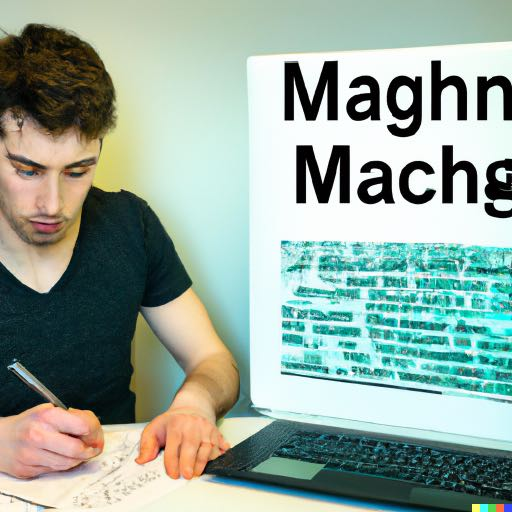

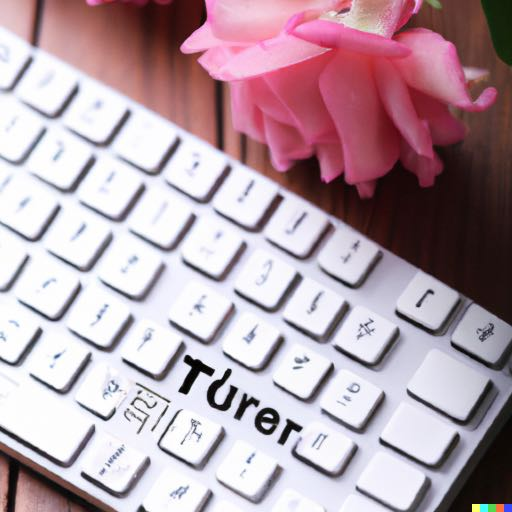

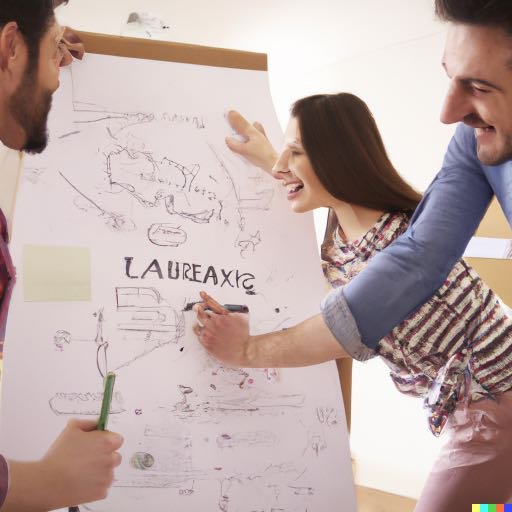